# 코드 제출용, 시간의지평선팀

## > Index <
    0.데이터 불러오기
    
    1.분류 별 판매량 추세
     -1.1.분류 별 추세 확인 데이터 만들기
     -1.2.이동평균 구하기
     -1.3.이동평균 시각화(추세)
     -1.4.누적평균 구하기
     -1.5.누적평균 시각화(추세)
     -1.6.추세산식
    
    2.브랜드 별 판매량 추세
     -2.1.브랜드 별 추세 확인 데이터 만들기
     -2.2.이동평균 구하기
     -2.3.이동평균 시각화(추세)
     -2.4.누적평균 구하기
     -2.5.누적평균 시각화(추세)
     -2.6.추세산식
    
    3.건당판매금액

In [1]:
# install tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 0.데이터 불러오기

In [2]:
# Prophet으로 보간된 데이터 불러오기
eunji = pd.read_csv('train_Prophet.csv')

In [3]:
# 소숫점 데이터 반올림: 실수(float) -> 정수(int) 
ejdata = eunji.iloc[:,-41:]  # 소숫점으로 표현된 구간
ndata = ejdata.round(decimals=0).astype(int)

In [4]:
# 반올림 데이터를 기존 데이터에 결합
eunji = eunji.drop(eunji.columns[-41:], axis=1)
train = pd.concat([eunji,ndata], axis=1)

## 1.'소분류' 별 월별 판매량 추세
#### 소분류는 총 53개 : 이정도는 그냥 플롯 보고 구체화 해도 될 듯?
#### 분류척도(4단계)
    -1:하락
    -2:상승 후 하락
    -3:하락 후 상승
    -4:상승

### 1.1.분류 별 판매량 추세 확인할 데이터 만들기

In [ ]:
# 소분류 별로 묶고
label_small = train.groupby('소분류').sum().transpose()
label_small = label_small.drop('ID')

In [ ]:
# index를 datetime화
label_index = pd.date_range(start='2022-01-01', end='2023-04-04')
label_small.index = pd.to_datetime(label_index)

In [ ]:
# datetime별로 월별 판매량으로 묶고 4월 판매량 빼기 (4일 밖에 없으니)
label_small['Date'] = pd.to_datetime(label_small.index)
label_df = label_small.groupby(pd.Grouper(key='Date', freq='M')).sum()
label_df = label_df.drop('2023-04-30')

In [ ]:
# 예시 데이터 시각화
sns.lineplot(data = label_df, x='Date', y='B002-C003-0001')

### 1.2.이동평균 구하기

In [ ]:
# 이동평균으로 다시 만들어보기 (이미 월별로 해서 꽤 완화됐는데 또 3개월을?)
label_MA3 = pd.DataFrame()
label_MA6 = pd.DataFrame()

for item in label_df:
    label_MA3[item] = label_df[item].rolling(3).mean()
    label_MA6[item] = label_df[item].rolling(6).mean()
    
# 이미 월별 산술합산으로 조정됐는데 또 이동평균을 하면..??

### 1.3.이동평균 시각화

In [ ]:
# 예시 플롯

# X3: 소분류 별 월별 판매량 3개월 이동평균 (train_MA3의 'B002-C003-0001')
X3 = label_MA3.loc[:,'B002-C003-0001']
# X6: 소분류 별 월별 판매량 6개월 이동평균 (train_MA6의 'B002-C003-0001')    
X6 = label_MA6.loc[:,'B002-C003-0001']


# plot 그려보기
plt.title('Trend Comparison per Label')

plt.plot(X3, label='Moving Average 3Months of Monthly Sales')   # 월별 판매량 3개월 이동평균 추세
plt.plot(X6, label='Moving Average 6Months of Monthly Sales')   # 월별 판매량 6개월 이동평균 추세

plt.xlabel('Date')
plt.ylabel('Total Amount of Sales')

plt.legend(loc='best', fontsize=9)
# plt.figure(figsize=(15,12))
plt.show()

### 1.4.누적평균 구하기
- 누적평균을 도입한 이유는 단순히 추세를 계산하는데 도움이 되지 않을까 하는..

In [ ]:
# 누적평균 구하기
lab_acc_mean = pd.DataFrame()

for item in label_df:
    lab_acc_mean[item] = label_df[item].expanding(axis=0).mean()
    
lab_acc_mean

### 1.5.누적평균 시각화

In [ ]:
# X: 소분류 별 월별 판매량 누적평균 (lab_acc_mean의 'B002-C003-0001')
X = lab_acc_mean.loc[:,'B002-C003-0001']
Y = label_df.loc[:,'B002-C003-0001']

# plot 그려보기
plt.title('Trend Comparison Per Label')

plt.plot(X, label='Accumulated Average of Monthly Sales')    # X가 월별 판매량 총합 추세
plt.plot(Y, label='Normal Average of Monthly Sales')         # Y가 월별 판매량 총합 추세
plt.xlabel('Date')
plt.ylabel('Total Amount of Sales')

plt.legend(loc='best', fontsize=9)
# plt.figure(figsize=(15,12))
plt.show()

### 1.6.추세산식

In [ ]:
# 이동평균을 활용한 추세 산출
# label_trend_Moving Average 3Months
label_trend_MA3 = pd.DataFrame(data = list(label_df.columns), columns=['소분류'])
label_trend_MA3['추세(2)'] = '999'

for i in range(53):
    if label_MA3.iloc[9:11+1,i].mean() < label_MA3.iloc[12:14+1,i].mean():      # 전체 평균보다 최근 평균이 높다
        label_trend_MA3.loc[i,'추세(2)'] = '2' # 2: 상승
    elif label_MA3.iloc[9:11+1,i].mean() > label_MA3.iloc[12:14+1,i].mean():       # 전체 평균보다 최근 평균이 낮다
        label_trend_MA3.loc[i,'추세(2)'] = '1' # 1: 하락
    else:
        label_trend_MA3.loc[i,'추세(2)'] = '0' # 0: 기타

label_trend_MA3

In [ ]:
#
label_trend_MA3['추세(2)'].value_counts(normalize=True)

In [ ]:
# 누적평균을 활용한 추세산출
# label_trend_Accumulated Mean
label_trend_AM = pd.DataFrame(data = list(label_df.columns), columns=['소분류'])
label_trend_AM['추세(2)'] = '999'

for i in range(53):
    if lab_acc_mean.iloc[13,i] < label_df.iloc[11:14,i].mean():      # 전체 평균보다 최근 평균이 높다
        label_trend_AM.loc[i,'추세(2)'] = '2' # 2: 상승
    elif lab_acc_mean.iloc[13,i] > label_df.iloc[11:14,i].mean():       # 전체 평균보다 최근 평균이 낮다
        label_trend_AM.loc[i,'추세(2)'] = '1' # 1: 하락
    else:
        label_trend_AM.loc[i,'추세(2)'] = '0' # 0: 기타
        
label_trend_AM

In [ ]:
#
label_trend_AM['추세(2)'].value_counts(normalize=True)

## 2. 브랜드 별 판매량 추세
### 2.1.브랜드 별 판매량 데이터 만들기

In [7]:
# 브랜드를 위한 데이터 만들기
brand = train.groupby('브랜드').sum()
brand = brand.drop(['ID'], axis=1)
brand_df = brand.transpose()

In [8]:
# 날짜를 datetime화
brand_df['Date'] = pd.to_datetime(brand_df.index)
brand_m = brand_df.groupby(pd.Grouper(key='Date', freq='M')).sum()
brand_m = brand_m.drop('2023-04-30')

In [10]:
# 기초통계량 파악
brand_stats = pd.DataFrame()

brand_stats['최소값'] = brand_m.min(axis=0)
brand_stats['최대값'] = brand_m.max(axis=0)
brand_stats['단순범위'] = brand_m.max(axis=0) - brand_m.min(axis=0)
brand_stats['Q1'] = brand_m.quantile(.25, axis=0)
brand_stats['Q3'] = brand_m.quantile(.75, axis=0)
brand_stats['사분위범위'] = brand_m.quantile(.75) - brand_m.quantile(.25)
brand_stats['평균'] = brand_m.mean(axis=0)
brand_stats['분산'] = brand_m.var(axis=0)
brand_stats['표준편차'] = brand_m.std(axis=0)

# brand_stats

### 2.2.이동평균 구하기

In [11]:
# 소요시간: 대략 0분 정도

brand_MA3 = pd.DataFrame()
brand_MA6 = pd.DataFrame()

for item in brand_m:
    brand_MA3[item] = brand_m[item].rolling(3).mean()    
    brand_MA6[item] = brand_m[item].rolling(6).mean()

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA3[item] = brand_m[item].rolling(3).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_MA6[item] = brand_m[item].rolling(6).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\2921159459.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

### 2.3.이동평균 시각화

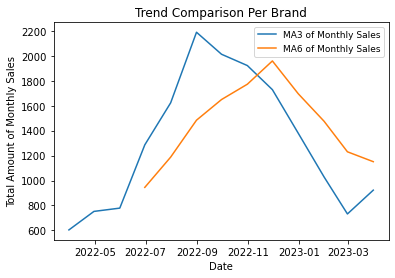

In [14]:
#
X3 = brand_MA3.loc[:,'B002-00003']
X6 = brand_MA6.loc[:,'B002-00003']

#
plt.title('Trend Comparison Per Brand')

plt.plot(X3, label='MA3 of Monthly Sales')     # X가 월별 판매량 총합 이동평균 3개월 추세
plt.plot(X6, label='MA6 of Monthly Sales')     # X가 월별 판매량 총합 이동평균 6개월 추세
plt.xlabel('Date')
plt.ylabel('Total Amount of Monthly Sales')

plt.legend(loc='best', fontsize=9)
# plt.figure(figsize=(20,15))
plt.show()

### 2.4.누적평균 구하기

In [15]:
brand_acc_mean = pd.DataFrame()

for item in brand_m:
    brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()

brand_acc_mean

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_acc_mean[item] = brand_m[item].expanding(axis=0).mean()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3364\432440340.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

,B002-00001,B002-00002,B002-00003,B002-00005,B002-00006,B002-00007,B002-00008,B002-00009,B002-00010,B002-00011,...,B002-03789,B002-03790,B002-03791,B002-03792,B002-03793,B002-03794,B002-03795,B002-03796,B002-03798,B002-03799
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-31,0.000000,7.000000,476.000000,59.000000,20.000000,233.000000,79.000000,0.000000,124.000000,0.000000,...,100.000000,18.000000,1.000000,0.000000,0.000000,0.000000,326.000000,4220.000000,279.000000,22.000000
2022-02-28,4.500000,132.000000,461.000000,789.000000,83.000000,190.500000,210.500000,0.000000,179.500000,0.000000,...,76.000000,26.000000,742.000000,32.500000,0.000000,0.000000,502.000000,4142.500000,2490.500000,39.000000
2022-03-31,4.000000,189.666667,604.333333,1219.000000,105.333333,164.000000,140.333333,0.000000,184.333333,28.000000,...,121.333333,27.000000,1039.000000,36.000000,0.000000,139.666667,434.333333,5914.000000,3486.333333,424.666667
2022-04-30,8.750000,333.250000,683.500000,1389.250000,112.500000,145.750000,133.250000,0.000000,168.750000,30.750000,...,157.250000,33.500000,1126.750000,33.750000,0.000000,142.750000,441.000000,6376.000000,3774.250000,487.000000
2022-05-31,13.400000,336.400000,651.800000,1408.400000,101.200000,128.000000,135.200000,0.000000,226.000000,28.200000,...,176.200000,31.200000,1558.400000,36.200000,0.000000,172.400000,457.200000,7004.600000,4283.400000,554.000000
2022-06-30,11.166667,358.166667,945.166667,1480.333333,92.833333,117.166667,125.500000,0.000000,238.333333,23.500000,...,187.166667,35.500000,1414.333333,37.833333,0.000000,197.333333,436.833333,7618.666667,4610.166667,581.500000
2022-07-31,9.571429,364.142857,1086.000000,1539.142857,87.714286,111.714286,108.142857,0.000000,243.857143,23.142857,...,179.000000,35.428571,1406.571429,39.571429,0.000000,203.428571,409.571429,8502.428571,5076.714286,619.285714
2022-08-31,8.375000,349.750000,1228.000000,1629.500000,82.375000,109.750000,94.625000,0.000000,236.625000,20.625000,...,159.750000,35.375000,1489.375000,43.000000,0.000000,207.250000,364.125000,8810.875000,5434.000000,605.250000
2022-09-30,7.555556,320.888889,1300.777778,1593.000000,73.444444,124.777778,106.111111,0.000000,235.555556,18.333333,...,143.222222,36.888889,1519.000000,40.444444,0.000000,197.000000,325.666667,9544.333333,5617.111111,642.222222


### 2.5.누적평균 시각화

In [20]:
# 플롯을 그려주기 위해 형식을 object -> datetime 으로 변환.
brand_acc_mean.index = pd.to_datetime(brand_acc_mean.index)

In [21]:
# X : 브랜드 별 월별 판매량 총합 (brand_m의 'B002-00003')
# Y : 브랜드 별 월별 판매량에 대한 누적평균 (bacc_mean의 'B002-00003')

X = brand_m.loc[:,'B002-00003']
Y = brand_acc_mean.loc[:,'B002-00003']

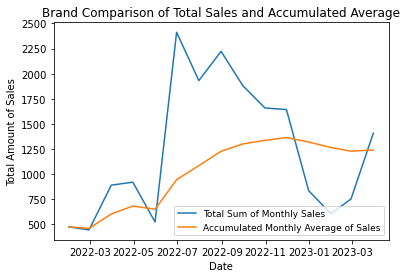

In [22]:
# plot 그려보기

plt.title('Brand Comparison of Total Sales and Accumulated Average')

plt.plot(X, label='Total Sum of Monthly Sales')     # X가 월별 판매량 총합 추세
plt.plot(Y, label='Accumulated Monthly Average of Sales')     # Y가 X의 월별 판매량을 누적평균한 흐름

plt.xlabel('Date')
plt.ylabel('Total Amount of Sales')

plt.legend(loc='best', fontsize=9)
# plt.figure(figsize=(15,12))
plt.show()

### 2.6.추세산식

In [23]:
# 비교구간 내 누적평균 대비 증감을 보기로 함.
brand_trend_MA3 = pd.DataFrame(data = list(brand_m.columns), columns=['브랜드'])
brand_trend_MA3['추세'] = '999'

for i in range(3170):
    if brand_MA3.iloc[9:11+1,i].mean() < brand_MA3.iloc[12:14+1,i].mean():      # 전체 평균보다 최근 평균이 높다
        brand_trend_MA3.loc[i,'추세'] = '2' # 2: going high
    elif brand_MA3.iloc[9:11+1,i].mean() > brand_MA3.iloc[12:14+1,i].mean():       # 전체 평균보다 최근 평균이 낮다
        brand_trend_MA3.loc[i,'추세'] = '1' # 1: going low
    else:
        brand_trend_MA3.loc[i,'추세'] = '0' # 0: stable

brand_trend_MA3

,브랜드,추세
0,B002-00001,2
1,B002-00002,1
2,B002-00003,1
3,B002-00005,1
4,B002-00006,1
...,...,...
3165,B002-03794,1
3166,B002-03795,2
3167,B002-03796,1
3168,B002-03798,2


In [24]:
brand_trend_MA3['추세'].value_counts()

1    1584
2    1252
0     334
Name: 추세, dtype: int64